## Chapter 11, Example 1 (GAN on Toy Data)

In [ ]:
# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# Other necessary imports
import os
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Sampling Functions for GAN

In the context of training a Generative Adversarial Network (GAN), we need to generate both real and fake data samples. The following functions are used to generate these samples:

### `sample_x`: Real Data Sampling Function

- `def sample_x(num_sample, num_dim):` defines a function to sample real data.
- `x = np.random.normal(loc=1.0, size=(num_sample, num_dim))` generates real data samples from a normal (Gaussian) distribution with a mean of 1.0 and the specified dimensions (`num_sample` and `num_dim`).
- `x = np.sort(x, axis=0)` sorts the generated samples along each dimension to introduce some structure in the data (optional and specific to the problem at hand).
- `return torch.from_numpy(x).float().to(device)` converts the samples to a PyTorch tensor, casts them to float type, and sends them to the specified device (e.g., CPU or GPU).

### `sample_z`: Noise Sampling Function for Generator Input

- `def sample_z(num_sample, num_dim):` defines a function to sample noise vectors.
- `z = np.linspace(-4, 6, num_sample) + np.random.random(num_sample) * 0.01` creates a linear space of values from -4 to 6, which is then perturbed by a small random noise to avoid uniformity.
- `z = np.expand_dims(z, axis=1)` reshapes the noise array to ensure it has the correct number of dimensions (`num_dim`).
- `return torch.from_numpy(z).float().to(device)` converts the noise array to a PyTorch tensor, casts them to float type, and sends them to the specified device.

These functions are typically called during the training loop of the GAN to provide inputs for the discriminator and generator, respectively.


In [ ]:
# Generate real data (inputs for discriminator)
def sample_x(num_sample, num_dim):
    x = np.random.normal(loc=1.0, size=(num_sample, num_dim))
    x = np.sort(x, axis=0)
    return torch.from_numpy(x).float().to(device)

# Generate uniform noise (inputs for generator)
def sample_z(num_sample, num_dim):
    z = np.linspace(-4, 6, num_sample) + np.random.random(num_sample) * 0.01
    z = np.expand_dims(z, axis=1)
    return torch.from_numpy(z).float().to(device)

## Generator and Discriminator Classes for GAN

In Generative Adversarial Networks (GANs), two neural networks, the Generator and the Discriminator, are trained simultaneously through adversarial processes. Below are the class definitions for both:

### Generator Class

- `class Generator(nn.Module):` defines the generator class that inherits from `nn.Module`.
- The generator takes a noise vector `z` as input and outputs data that aims to mimic the real data distribution.
- `self.net` is a sequential container of layers:
  - `nn.Linear(noise_dim, g1_dim)`: The first linear layer takes the noise vector of dimension `noise_dim` and maps it to a hidden layer of dimension `g1_dim`.
  - `nn.Tanh()`: A Tanh activation function that adds non-linearity after the first linear transformation.
  - `nn.Linear(g1_dim, g2_dim)`: The second linear layer maps the first hidden layer to another hidden layer of dimension `g2_dim`.
  - Another Tanh activation function follows.
  - `nn.Linear(g2_dim, data_dim)`: The final linear layer maps the second hidden layer to the output layer of dimension `data_dim`, which represents the generated data.

### Discriminator Class

- `class Discriminator(nn.Module):` defines the discriminator class that also inherits from `nn.Module`.
- The discriminator takes an input `x`, which could be either real data or generated data from the generator, and outputs a single scalar representing the probability that `x` is from the real data distribution.
- `self.net` is a sequential container of layers similar to the generator but typically with different dimensions:
  - `nn.Linear(data_dim, d1_dim)`: The first linear layer takes an input of dimension `data_dim` and maps it to a hidden layer of dimension `d1_dim`.
  - `nn.Tanh()`: A Tanh activation function for non-linearity.
  - `nn.Linear(d1_dim, d2_dim)`: The second linear layer maps the first hidden layer to another hidden layer of dimension `d2_dim`.
  - Another Tanh activation function follows.
  - `nn.Linear(d2_dim, 1)`: The final linear layer maps the second hidden layer to a single output, indicating the probability of the input being real.

The forward methods in both classes define how the data flows through the networks:

- In `Generator`, `def forward(self, z):` takes a noise vector `z` and passes it through the network to produce generated data.
- In `Discriminator`, `def forward(self, x):` takes either real or generated data `x` and outputs the probability of `x` being real.

These classes are instantiated and used during the training process where the generator learns to produce data that is indistinguishable from real data, while the discriminator learns to distinguish between real and generated data.


In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim, g1_dim, g2_dim, data_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, g1_dim),
            nn.Tanh(),
            nn.Linear(g1_dim, g2_dim),
            nn.Tanh(),
            nn.Linear(g2_dim, data_dim)
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, data_dim, d1_dim, d2_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dim, d1_dim),
            nn.Tanh(),
            nn.Linear(d1_dim, d2_dim),
            nn.Tanh(),
            nn.Linear(d2_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

## Loss Functions for GAN Training

In the training of Generative Adversarial Networks (GANs), two distinct loss functions are used for the discriminator and the generator. Below is the implementation of these loss functions using PyTorch:

### Binary Cross Entropy Loss

- `criterion = nn.BCEWithLogitsLoss()`: This creates a criterion that measures Binary Cross Entropy between the target and the output logits (predictions before applying sigmoid).

### Discriminator Loss Function

- `def discriminator_loss(real_prediction, fake_prediction):` defines the loss function for the discriminator.
  - `real_loss = criterion(real_prediction, torch.ones_like(real_prediction))`: Computes the loss for real images where the target is all ones (since real images should be classified as 1).
  - `fake_loss = criterion(fake_prediction, torch.zeros_like(fake_prediction))`: Computes the loss for fake images generated by the generator where the target is all zeros (since fake images should be classified as 0).
  - The total loss for the discriminator is the sum of `real_loss` and `fake_loss`.

### Generator Loss Function

- `def generator_loss(fake_prediction):` defines the loss function for the generator.
  - This function computes the loss for the generator's fake images with the target being all ones because the generator's goal is to fool the discriminator into thinking the fake images are real.

The discriminator aims to correctly classify real and fake data, hence the two-part loss function. The generator, on the other hand, tries to generate data that is classified as real by the discriminator, hence the single-part loss function.

These loss functions are used during the training process where the discriminator and generator are updated in an alternating fashion to improve their performances against each other.


In [ ]:
# Binary Cross Entropy Loss
criterion = nn.BCEWithLogitsLoss()

def discriminator_loss(real_prediction, fake_prediction):
    real_loss = criterion(real_prediction, torch.ones_like(real_prediction))
    fake_loss = criterion(fake_prediction, torch.zeros_like(fake_prediction))
    return real_loss + fake_loss

def generator_loss(fake_prediction):
    return criterion(fake_prediction, torch.ones_like(fake_prediction))

In [ ]:
def plot(iter, generator, discriminator, num_sample):
    xs = np.linspace(-4, 6, 100)
    real_sample = sample_x(num_sample, 1)

    z = sample_z(num_sample, 1)
    with torch.no_grad():
        fake_sample = generator(z).view(-1).cpu().numpy()
    histc, edges = np.histogram(fake_sample, bins=100, range=(-4, 6))
    histr, edges = np.histogram(real_sample.cpu().numpy(), bins=100, range=(-4, 6))

    plt.plot(xs, histr / num_sample, label='p_data')
    plt.plot(xs, histc / num_sample, label='p_g')
    plt.ylim([0, 0.1])
    plt.legend()
    plt.savefig(f'eg11.1_pytorch/iter{iter:06d}.png')
    plt.close()

## Training Step for GAN

The `train_step` function encapsulates a single step of training for both the generator and discriminator within a Generative Adversarial Network (GAN). Here's a breakdown of the process:

### Zeroing Gradients
- `generator_optimizer.zero_grad()` and `discriminator_optimizer.zero_grad()`: Before the forward pass, we zero out the gradients from the previous step to prevent accumulation.

### Forward Pass
- `fake_sample = generator(noise)`: The generator creates a fake sample from the input noise.
- `real_prediction = discriminator(real_sample)`: The discriminator makes a prediction on a real sample.
- `fake_prediction = discriminator(fake_sample.detach())`: The discriminator also makes a prediction on the fake sample generated by the generator. The `detach()` method is used to prevent gradients from flowing into the generator during the discriminator's update.

### Updating Discriminator
- `loss_disc = discriminator_loss(real_prediction, fake_prediction)`: Calculate the discriminator's loss based on its predictions on real and fake data.
- `loss_disc.backward()`: Perform backpropagation for the discriminator, calculating the gradients.
- `discriminator_optimizer.step()`: Update the discriminator's weights.

### Updating Generator
- `fake_prediction_for_gen = discriminator(fake_sample)`: The discriminator makes a prediction on the fake sample again, this time for updating the generator.
- `loss_gen = generator_loss(fake_prediction_for_gen)`: Calculate the generator's loss based on the discriminator's prediction.
- `loss_gen.backward()`: Perform backpropagation for the generator.
- `generator_optimizer.step()`: Update the generator's weights.

### Return Values
- The function returns the loss values for both the generator (`loss_gen.item()`) and the discriminator (`loss_disc.item()`), which can be used to monitor the training process.

This training step is typically run in a loop over many epochs to train the GAN until the generator produces realistic data and the discriminator becomes good at telling real from fake.


In [ ]:
def train_step(generator, discriminator, real_sample, noise, generator_optimizer, discriminator_optimizer):
    # Zero the parameter gradients
    generator_optimizer.zero_grad()
    discriminator_optimizer.zero_grad()

    # Forward pass
    fake_sample = generator(noise)
    real_prediction = discriminator(real_sample)
    fake_prediction = discriminator(fake_sample.detach())

    # Update discriminator
    loss_disc = discriminator_loss(real_prediction, fake_prediction)
    loss_disc.backward()
    discriminator_optimizer.step()

    # Update generator
    fake_prediction_for_gen = discriminator(fake_sample)
    loss_gen = generator_loss(fake_prediction_for_gen)
    loss_gen.backward()
    generator_optimizer.step()

    return loss_gen.item(), loss_disc.item()

In [ ]:
# Create the folder to store images
if not os.path.exists('eg11.1_pytorch/'):
    os.makedirs('eg11.1_pytorch/')

# Hyperparameters and initializations
num_iter = 70000
batch_size = 1000
num_sample = 10000  # used in plot

noise_dim = 1
g1_dim = 5
g2_dim = 5
data_dim = 1
d1_dim = 10
d2_dim = 10

# Set random seed for reproducibility
seed = 100
np.random.seed(seed)
torch.manual_seed(seed)

iteration: 1000, loss_disc: 1.333, loss_gen: 0.7444
iteration: 2000, loss_disc: 1.367, loss_gen: 0.7323
iteration: 3000, loss_disc: 1.372, loss_gen: 0.6958
iteration: 4000, loss_disc: 1.414, loss_gen: 0.6779
iteration: 5000, loss_disc: 1.358, loss_gen: 0.7097
iteration: 6000, loss_disc: 1.4, loss_gen: 0.6905
iteration: 7000, loss_disc: 1.361, loss_gen: 0.7114
iteration: 8000, loss_disc: 1.364, loss_gen: 0.7007
iteration: 9000, loss_disc: 1.377, loss_gen: 0.7086
iteration: 10000, loss_disc: 1.368, loss_gen: 0.6899
iteration: 11000, loss_disc: 1.361, loss_gen: 0.7231
iteration: 12000, loss_disc: 1.323, loss_gen: 0.7172
iteration: 13000, loss_disc: 1.317, loss_gen: 0.7417
iteration: 14000, loss_disc: 1.32, loss_gen: 0.7505
iteration: 15000, loss_disc: 1.287, loss_gen: 0.7698
iteration: 16000, loss_disc: 1.225, loss_gen: 0.7918
iteration: 17000, loss_disc: 1.346, loss_gen: 0.7588
iteration: 18000, loss_disc: 1.328, loss_gen: 0.7063
iteration: 19000, loss_disc: 1.383, loss_gen: 0.7593
itera

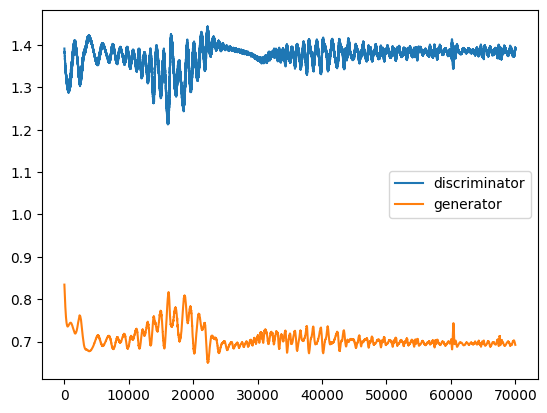

In [1]:
# Create generator and discriminator
generator = Generator(noise_dim, g1_dim, g2_dim, data_dim).to(device)
discriminator = Discriminator(data_dim, d1_dim, d2_dim).to(device)

# Adam optimizer
lr = 1e-4
generator_optimizer = optim.Adam(generator.parameters(), lr=lr)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

# Plot results before training
plot(0, generator, discriminator, num_sample)

# Training loop
genloss_l = []
discloss_l = []
for iter in range(1, num_iter + 1):
    real_sample = sample_x(batch_size, data_dim)
    noise = sample_z(batch_size, noise_dim)
    loss_gen, loss_disc = train_step(generator, discriminator, real_sample, noise, generator_optimizer, discriminator_optimizer)
    genloss_l.append(loss_gen)
    discloss_l.append(loss_disc)

    if iter % 1000 == 0:
        print(f'iteration: {iter}, loss_disc: {loss_disc:.4}, loss_gen: {loss_gen:.4}')
        plot(iter, generator, discriminator, num_sample)

# Plot the training curves
print('----Training Curves----')
plt.plot(range(len(genloss_l)), discloss_l, label='discriminator')
plt.plot(range(len(genloss_l)), genloss_l, label='generator')
plt.legend()
plt.savefig('eg11.1_pytorch/training_curve.png')
plt.show()
